In [83]:
import importlib

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

from crule import evaluation
from crule.evaluation import friedman_nemenyi, plot_critical_difference

evaluation = importlib.reload(evaluation)

In [84]:
def rul_score(dist):
    factors = np.ones_like(dist)
    factors[dist >= 0] /= 10.0
    factors[dist < 0] /= -13.0
    dist = np.exp(dist * factors) - 1.0
    score = dist

    return score

# Unsupervised Domain Adaptation for RUL Estimation
## A Benchmark

In [85]:
def radar_factory(num_vars, frame='circle', tname="radar"):
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = tname
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

In [86]:
approach_names = {
    "AdaRulApproach": "AdaRUL",
    "ConditionalDannApproach": "Conditional DANN",
    "ConditionalMmdApproach": "Conditional MMD",
    "ConsistencyApproach": "Consistency",
    "DannApproach": "DANN",
    "LatentAlignApproach": "Latent Alignment",
    "MmdApproach": "MMD",
    "NoAdaptionApproach": "No Adaptation",
    "PseudoLabelsApproach": "Pseudo Labels",
}
dataset_names = {
    "cmapss": "C-MAPSS",
    "femto": "FEMTO",
    "xjtu-sy": "XJTU-SY",
}

In [87]:
rmse = pd.read_csv("results/rmse.csv", header=[0, 1, 2, 3], index_col=[0, 1, 2])
rounded = rmse.copy()
rounded.loc[:, (slice(None), "cmapss")] = rounded.loc[:, (slice(None), "cmapss")].round(1)
score = pd.read_csv("results/score.csv", header=[0, 1, 2, 3], index_col=[0, 1, 2])
score_adjusted = score.copy()
score_adjusted.loc[:, (slice(None), "femto")] = 1 - score_adjusted.loc[:, (slice(None), "femto")]
score_adjusted.loc[:, (slice(None), "xjtu-sy")] = 1 - score_adjusted.loc[:, (slice(None), "xjtu-sy")]

# CNN vs. LSTM
Findings:
* CNN and LSTM perform equally on average
* Some approaches perform better on CNN, some on LSTM
* Overall differences are minimal while standard deviations are high

In [119]:
backbones = rounded.loc[("transductive",), (slice(None), "cmapss")]

def grouped_bar(performance, axis = None):
    x = np.arange(8)
    width = 1 / 3
    multiplier = 0
    if axis is None:
        fig, axis = plt.subplots(figsize=(9, 4))
    colors = {"cnn": "tab:blue", "lstm": "tab:green"}
    for label, data in performance.groupby(level="backbone"):
        offset = width * multiplier
        rects = axis.bar(x + offset, data["mean"], width, label=label.upper(), color=colors[label])
        axis.errorbar(x + offset, data["mean"], data["std"], fmt="none", color="black", capsize=3)
        # axis.bar_label(rects, padding=3, fmt="%.1f")
        multiplier += 1
    approaches = performance.index.get_level_values("approach").map(approach_names.get)[:8]
    axis.set_ylabel("RMSE")
    axis.set_xticks(x + width / 2, approaches, rotation=20, ha="right")
    axis.legend()
    
    return fig, axis

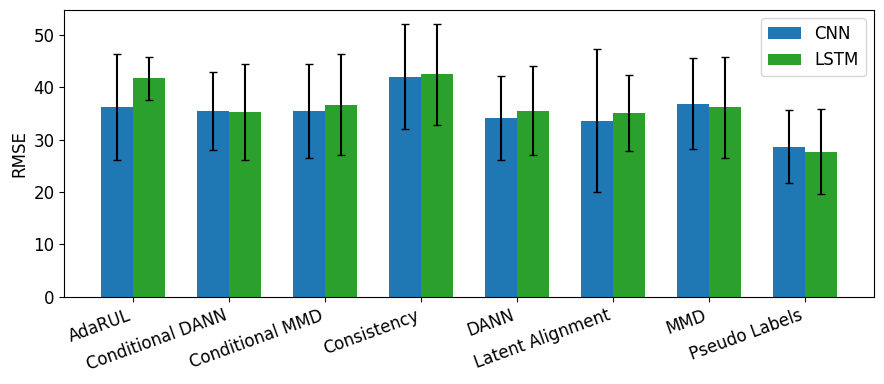

In [120]:
plt.rc('font', **{'size': 12})
avg_backbones = backbones.drop("NoAdaptionApproach", level="approach").agg(["mean", "std"], axis=1)
fig, axis = grouped_bar(avg_backbones)
fig.tight_layout()
fig.savefig("plots/backbones.pdf", bbox_inches="tight")
plt.rcdefaults()

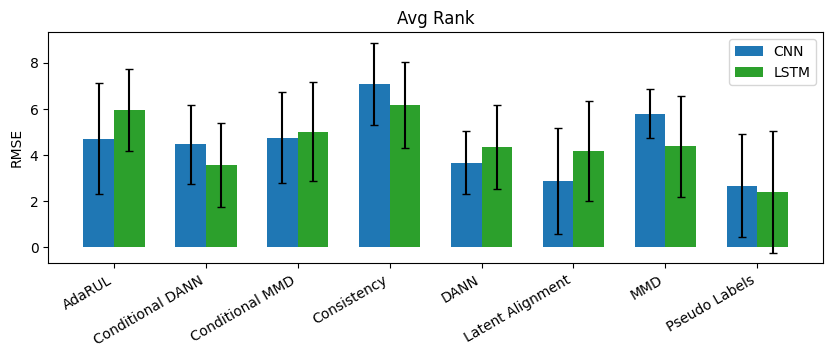

In [90]:
ranked_backbones = backbones.drop("NoAdaptionApproach", level="approach")
for backbone, group in ranked_backbones.groupby(level="backbone"):
    ranked_backbones.loc[backbone] = group.rank()
ranked_backbones = ranked_backbones.agg(["mean", "std"], axis=1)
_, axis = grouped_bar(ranked_backbones)
_ = axis.set_title("Avg Rank")

# Transductive vs. Inductive
Findings:
* Even less difference than between CNN and LSTM
* Score shows a bigger difference, but this is probably because it is an exponential measure
* log(Score) shows similar differences as RMSE
* Data scenario may partially explain lack of difference:
    * Train set has 80% scenario
    * Test set equivalent to 60% scenario
    * Repetition with 60% training scenario still shows little difference 

In [91]:
def avg_bar_adaption_mode(performance, axis = None, agg = "mean", plot="bar", color="tab:blue", order = None):
    vs_transductive = performance.drop(["complete"], level="adaption_mode").loc[(slice(None), "cnn"), (slice(None), "cmapss")]
    vs_transductive = vs_transductive.drop("NoAdaptionApproach", level="approach")
    
    if agg == "mean":
        avg_vs_transductive = vs_transductive.groupby(level="adaption_mode").mean().mean(axis=1)
    else:
        avg_vs_transductive = vs_transductive.groupby(level="approach").rank().groupby(level="adaption_mode").mean().mean(axis=1)
    
    if order is not None:
        avg_vs_transductive = avg_vs_transductive.loc[order]
    
    if axis is None:
        fig, axis = plt.subplots(figsize=(16, 2))
    
    if plot == "bar":
        rects = axis.bar(avg_vs_transductive.index, avg_vs_transductive)
        axis.bar_label(rects, padding=3)
    else:
        axis.plot(avg_vs_transductive.index, avg_vs_transductive, marker="o", color=color)
    
    return axis

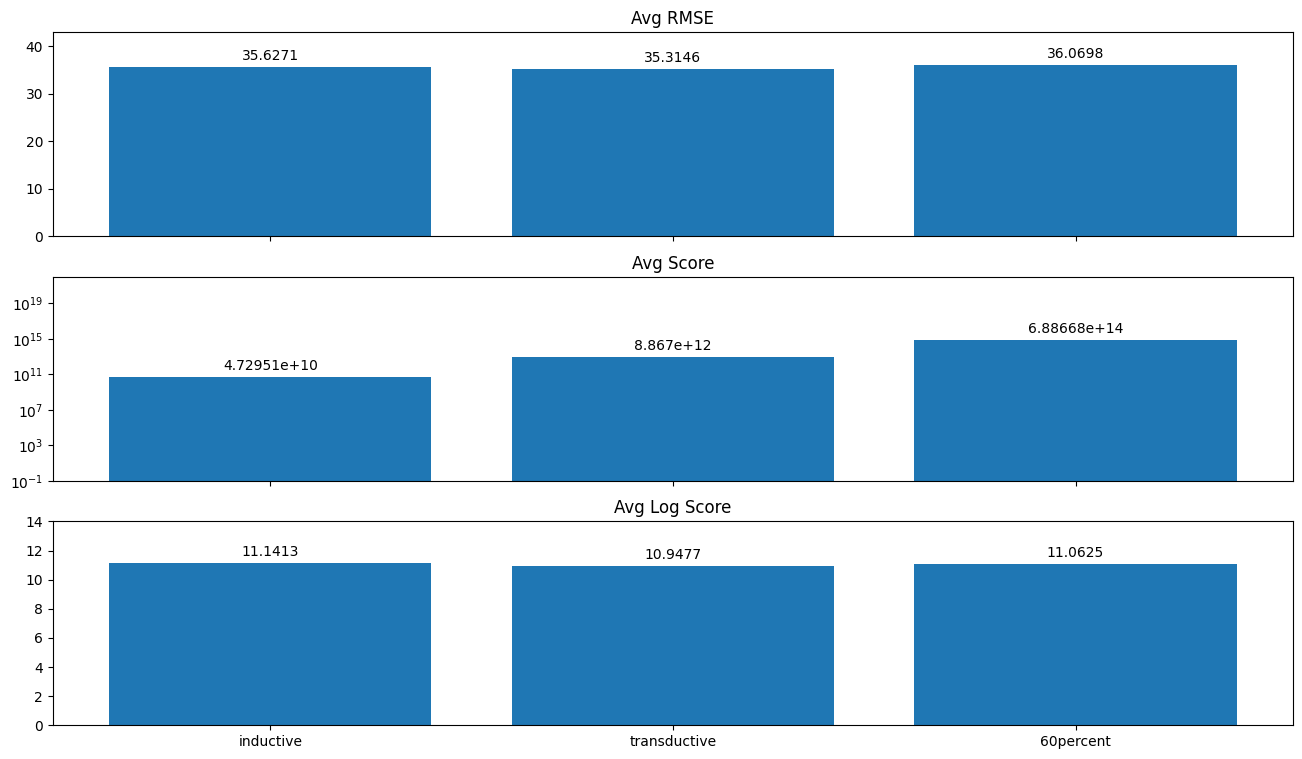

In [92]:
_, (rmse_axis, score_axis, log_score_axis) = plt.subplots(figsize=(16, 9), ncols=1, nrows=3, sharex="all")
order = ["inductive", "transductive", "60percent"]
axis = avg_bar_adaption_mode(rounded, rmse_axis, order=order)
axis.set_ylim(0, 43)
_ = axis.set_title("Avg RMSE")

axis = avg_bar_adaption_mode(score, score_axis, order=order)
axis.set_yscale("log")
axis.set_ylim(0.1, 1e22)
_  = axis.set_title("Avg Score")

axis = avg_bar_adaption_mode(np.log(score), log_score_axis, order=order)
axis.set_ylim(0, 14)
_  = axis.set_title("Avg Log Score")

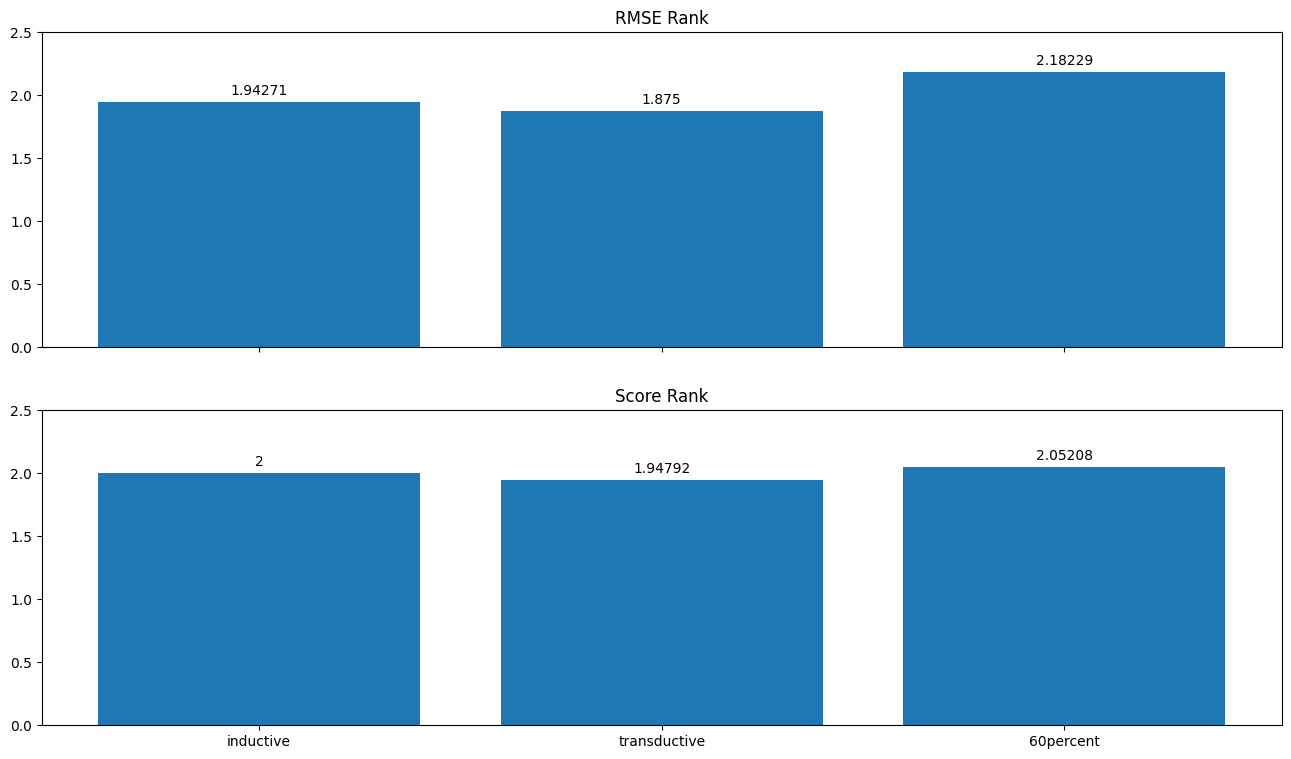

In [93]:
_, (rmse_axis, score_axis) = plt.subplots(figsize=(16, 9), ncols=1, nrows=2, sharex="all")
axis = avg_bar_adaption_mode(rounded, rmse_axis, agg="rank", order=order)
axis.set_ylim(0, 2.5)
_ = axis.set_title("RMSE Rank")

axis = avg_bar_adaption_mode(score, score_axis, agg="rank", order=order)
axis.set_ylim(0, 2.5)
_  = axis.set_title("Score Rank")

(1.7, 2.3)

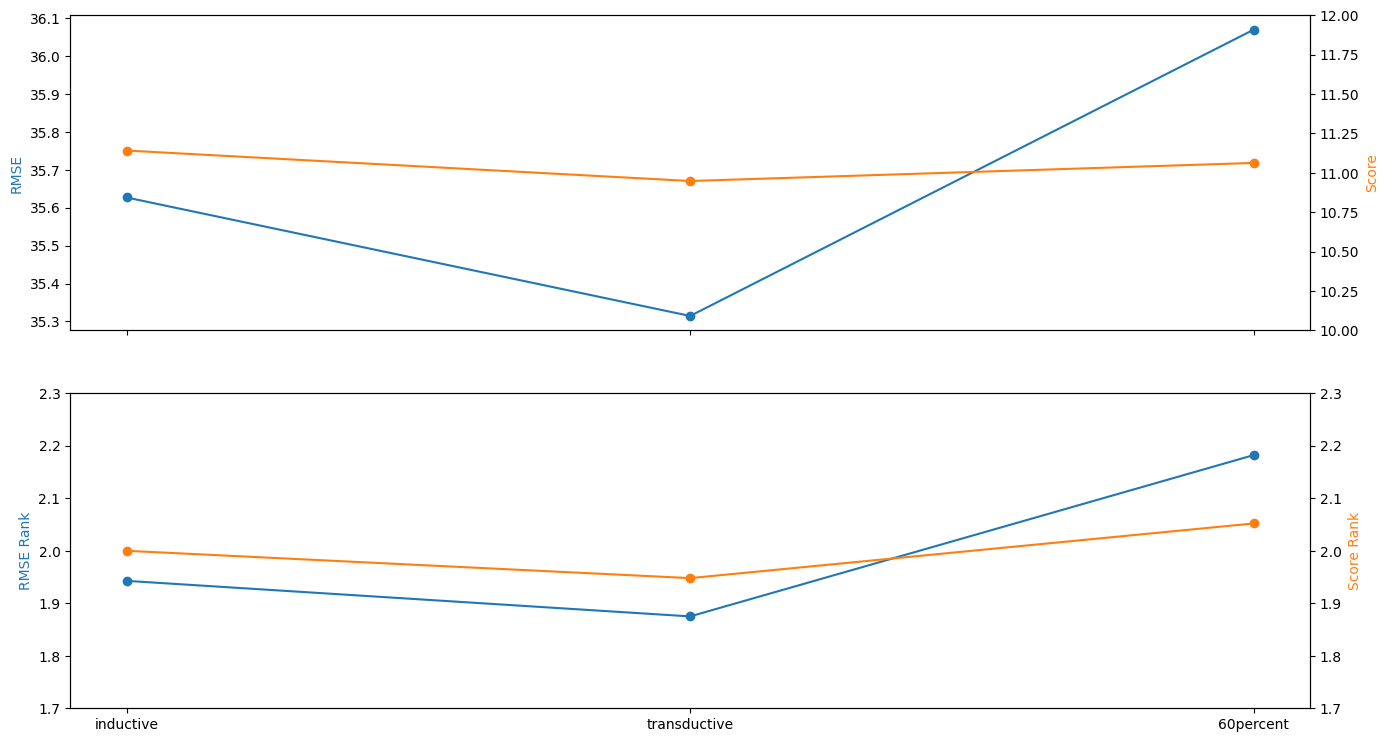

In [94]:
_, (axis, rank_axis) = plt.subplots(figsize=(16, 9), nrows=2, sharex="all")

avg_bar_adaption_mode(rounded, axis, plot="line", order=order)
axis.set_ylabel("RMSE", color="tab:blue")
twin_axis = axis.twinx()
avg_bar_adaption_mode(np.log(score), twin_axis, plot="line", color="tab:orange", order=order)
twin_axis.set_ylabel("Score", color="tab:orange")
_ = twin_axis.set_ylim(10, 12)

avg_bar_adaption_mode(rounded, rank_axis, agg="rank", plot="line", order=order)
rank_axis.set_ylabel("RMSE Rank", color="tab:blue")
rank_axis.set_ylim(1.7, 2.3)
twin_axis = rank_axis.twinx()
avg_bar_adaption_mode(np.log(score), twin_axis, agg="rank", plot="line", color="tab:orange", order=order)
twin_axis.set_ylabel("Score Rank", color="tab:orange")
twin_axis.set_ylim(1.7, 2.3)

# Data Scenario
Findings:
* Again only small differences
* 80% is, intuitively, better than 100% data scenario
* 80% may be better because hyperparameter search was conducted in this scenario
* 60%, as expected, is worse than 80% and 100%

In [95]:
def avg_bar_data_scenario(performance, axis = None, agg = "mean", plot="bar", color="tab:blue", order = None):
    vs_transductive = performance.drop(["inductive"], level="adaption_mode").loc[(slice(None), "cnn"), (slice(None), "cmapss")]
    vs_transductive = vs_transductive.drop("NoAdaptionApproach", level="approach")
    
    if agg == "mean":
        avg_vs_transductive = vs_transductive.groupby(level="adaption_mode").mean().mean(axis=1)
    else:
        avg_vs_transductive = vs_transductive.groupby(level="approach").rank().groupby(level="adaption_mode").mean().mean(axis=1)
    
    if order is not None:
        avg_vs_transductive = avg_vs_transductive.loc[order]
    
    if axis is None:
        fig, axis = plt.subplots(figsize=(16, 2))
    
    if plot == "bar":
        rects = axis.bar(avg_vs_transductive.index, avg_vs_transductive)
        axis.bar_label(rects, padding=3)
    else:
        axis.plot(avg_vs_transductive.index, avg_vs_transductive, marker="o", color=color)
    
    return axis

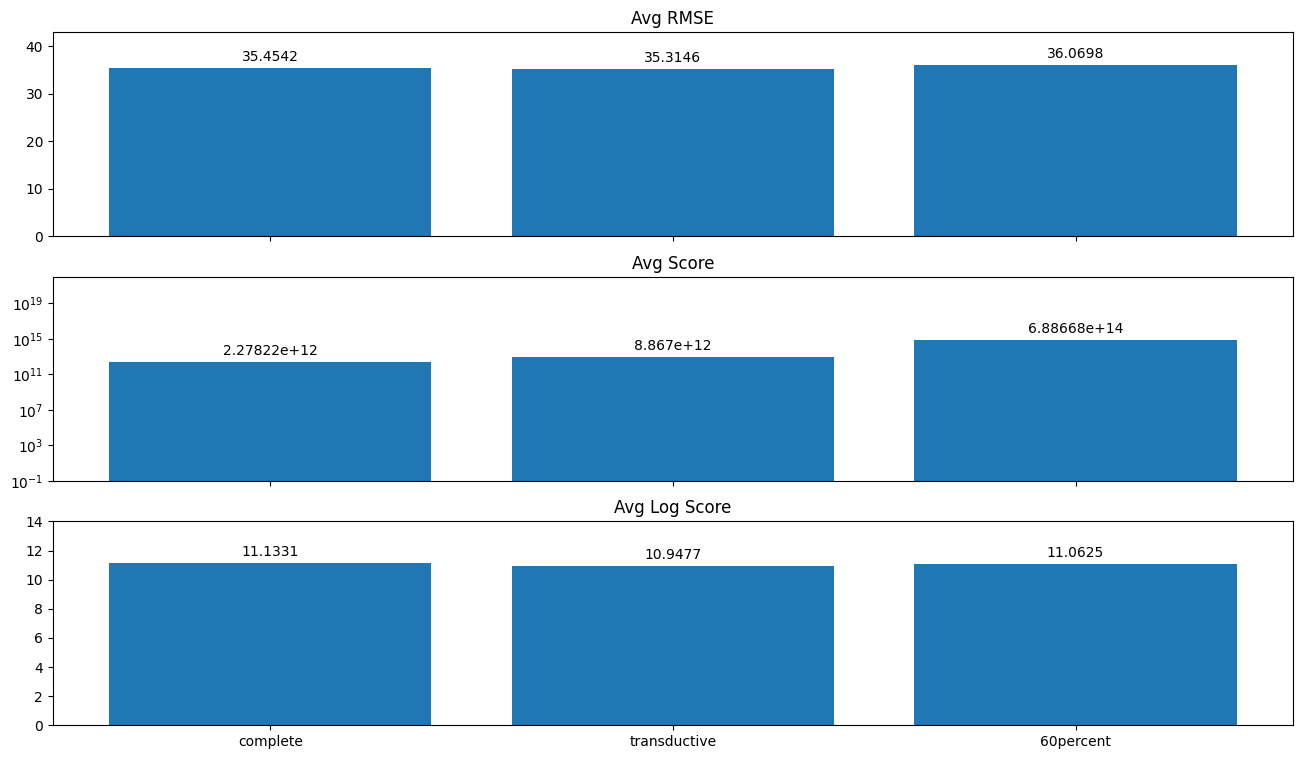

In [96]:
_, (rmse_axis, score_axis, log_score_axis) = plt.subplots(figsize=(16, 9), ncols=1, nrows=3, sharex="all")
order = ["complete", "transductive", "60percent"]
axis = avg_bar_data_scenario(rounded, rmse_axis, order=order)
axis.set_ylim(0, 43)
_ = axis.set_title("Avg RMSE")

axis = avg_bar_data_scenario(score, score_axis, order=order)
axis.set_yscale("log")
axis.set_ylim(0.1, 1e22)
_  = axis.set_title("Avg Score")

axis = avg_bar_data_scenario(np.log(score), log_score_axis, order=order)
axis.set_ylim(0, 14)
_  = axis.set_title("Avg Log Score")

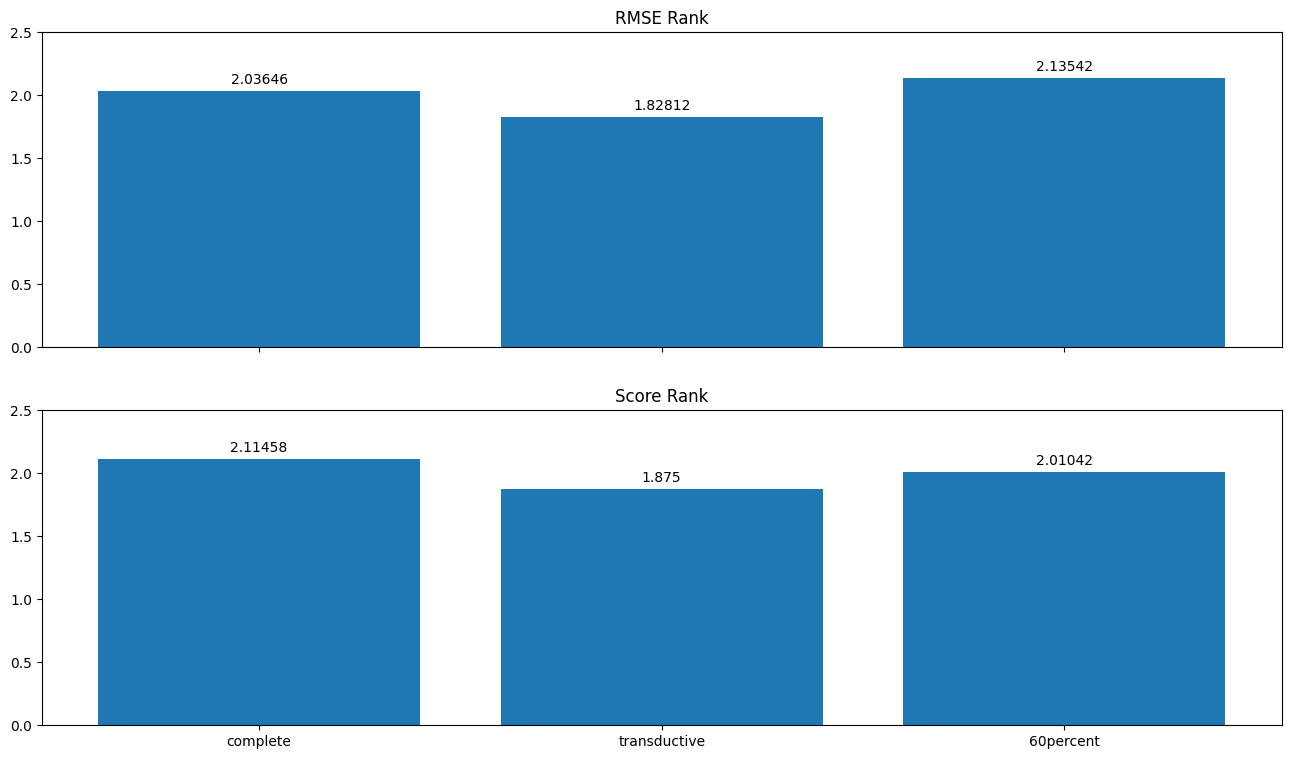

In [97]:
_, (rmse_axis, score_axis) = plt.subplots(figsize=(16, 9), ncols=1, nrows=2, sharex="all")
axis = avg_bar_data_scenario(rounded, rmse_axis, agg="rank", order=order)
axis.set_ylim(0, 2.5)
_ = axis.set_title("RMSE Rank")

axis = avg_bar_data_scenario(score, score_axis, agg="rank", order=order)
axis.set_ylim(0, 2.5)
_  = axis.set_title("Score Rank")

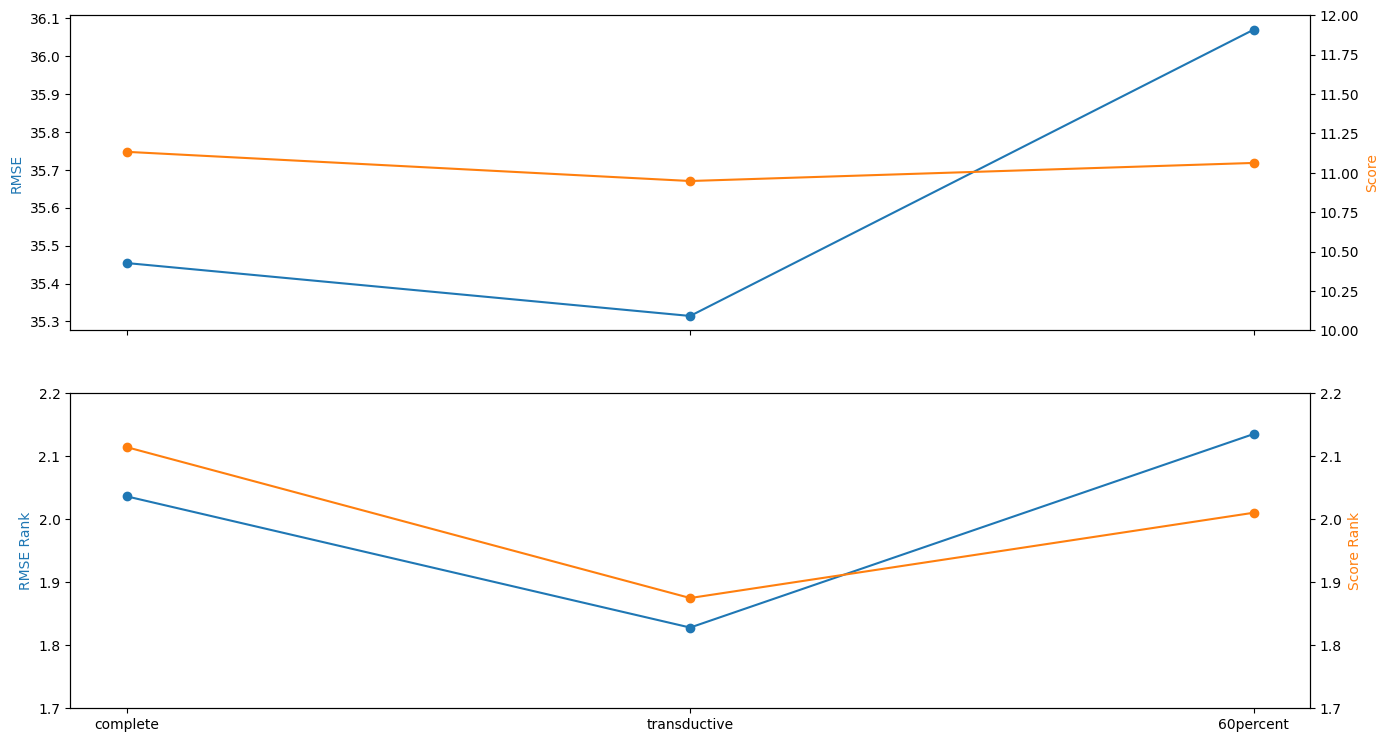

In [98]:
_, (axis, rank_axis) = plt.subplots(figsize=(16, 9), nrows=2, sharex="all")

avg_bar_data_scenario(rounded, axis, plot="line", order=order)
axis.set_ylabel("RMSE", color="tab:blue")
twin_axis = axis.twinx()
avg_bar_data_scenario(np.log(score), twin_axis, plot="line", color="tab:orange", order=order)
twin_axis.set_ylabel("Score", color="tab:orange")
_ = twin_axis.set_ylim(10, 12)

avg_bar_data_scenario(rounded, rank_axis, agg="rank", plot="line", order=order)
rank_axis.set_ylabel("RMSE Rank", color="tab:blue")
rank_axis.set_ylim(1.7, 2.2)
twin_axis = rank_axis.twinx()
avg_bar_data_scenario(np.log(score), twin_axis, agg="rank", plot="line", color="tab:orange", order=order)
twin_axis.set_ylabel("Score Rank", color="tab:orange")
_ = twin_axis.set_ylim(1.7, 2.2)

# RMSE Radar Plot
Findings:
* Approaches perform reliably on C-CMAPSS
* Inconsistent performance on FEMTO and XJTU-SY
* Baseline often outperforms UDA approaches on bearing datasets
* C-MAPSS may have become too easy for UDA
* Previous work may not have shown low performance on bearing datasets because they did not run all adaptation tasks

In [99]:
def radar(rmse, add_legend=True):
    theta12 = radar_factory(12, frame="polygon", tname="radar_12")
    theta6 = radar_factory(6, frame="polygon", tname="radar_6")
    fig = plt.figure(figsize=(16, 9))
    axes = [fig.add_subplot(1, 3, i, projection=f'radar_{n}') for i, n in enumerate([12, 6, 6], start=1)]
    colors = list(matplotlib.colors.TABLEAU_COLORS)[:9][::-1]

    for dataset, axis, theta in zip(["cmapss", "femto", "xjtu-sy"], axes, [theta12, theta6, theta6]):
        legend = []
        filtered = rmse.loc[:, (slice(None), dataset)].droplevel([0, 1], axis=1)
        axis.set_varlabels(["→".join(c) for c in filtered.columns])
        axis.set_title(dataset_names[dataset])
        max_rmse = filtered.values.max()
        for idx, (color, (approach, data)) in enumerate(zip(colors, filtered.sort_index().iterrows())):
            if approach == "NoAdaptionApproach":
                outer_border = np.vstack([theta, np.repeat(max_rmse + 1000, len(data))]).T
                inner_border = np.vstack([theta, data.values]).T
                codes = np.ones(len(data), dtype=matplotlib.path.Path.code_type) * matplotlib.path.Path.LINETO
                codes[0] = matplotlib.path.Path.MOVETO
                vertices = np.concatenate([outer_border, inner_border[::-1]])
                path = matplotlib.path.Path(vertices, np.tile(codes, 2))
                patch = matplotlib.patches.PathPatch(path, facecolor="grey", alpha=0.4, zorder=4)
                axis.add_patch(patch)
                axis.plot(
                    theta, data, color="black", alpha=0.4, linestyle="--", linewidth=1.5, zorder=5, label=approach_names[approach]
                )
            else:
                axis.plot(theta, data, color=color, linewidth=1.5, label=approach_names[approach])
        axis.set_ylim(0, max_rmse * 1.1)
    if add_legend:
        artist = axes[1].legend(fontsize="small", loc=(0.75, 0.91), ncols=2)
        artist.set_in_layout(False)
    
    return fig, axes

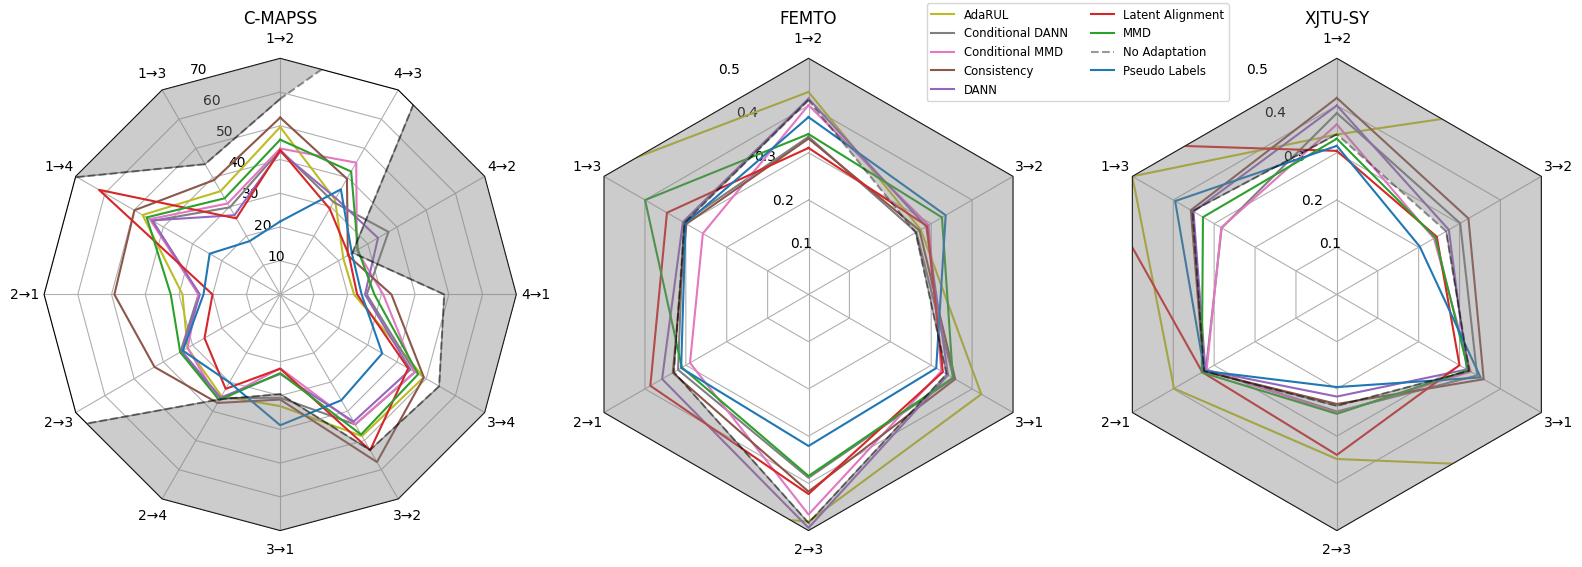

In [100]:
fig, axes = radar(rmse.loc[("transductive", "cnn")])
_ = axes[0].set_ylim(0, 70)
_ = axes[1].set_ylim(0, 0.5)
_ = axes[2].set_ylim(0, 0.5)
fig.tight_layout()
fig.savefig("plots/rmse_radar.pdf", bbox_inches="tight")

# Score Radar Plot

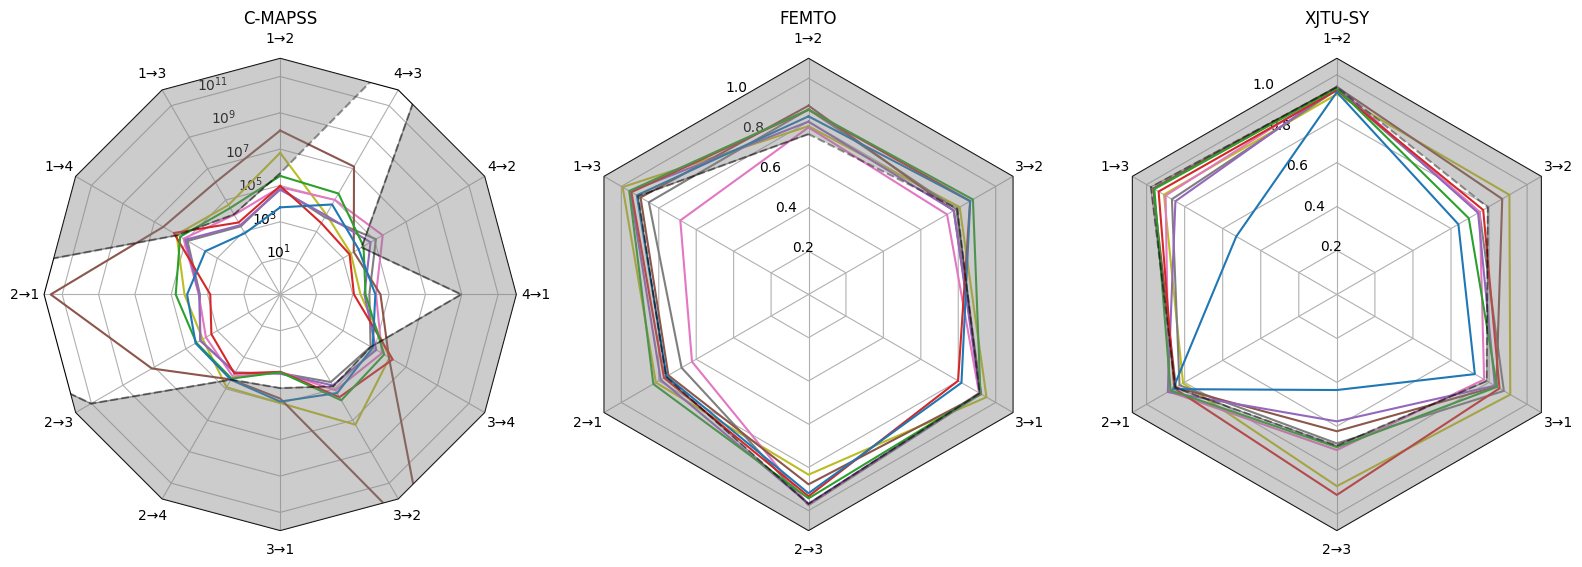

In [101]:
fig, axes = radar(score_adjusted.loc[("transductive", "cnn")], add_legend=False)
axes[0].set_yscale("log")
_ = axes[0].set_ylim(0.1, 1e12)
fig: plt.Figure
fig.tight_layout()
fig.savefig("plots/score_radar.pdf", bbox_inches="tight")

# Ranks RMSE Radar Plot

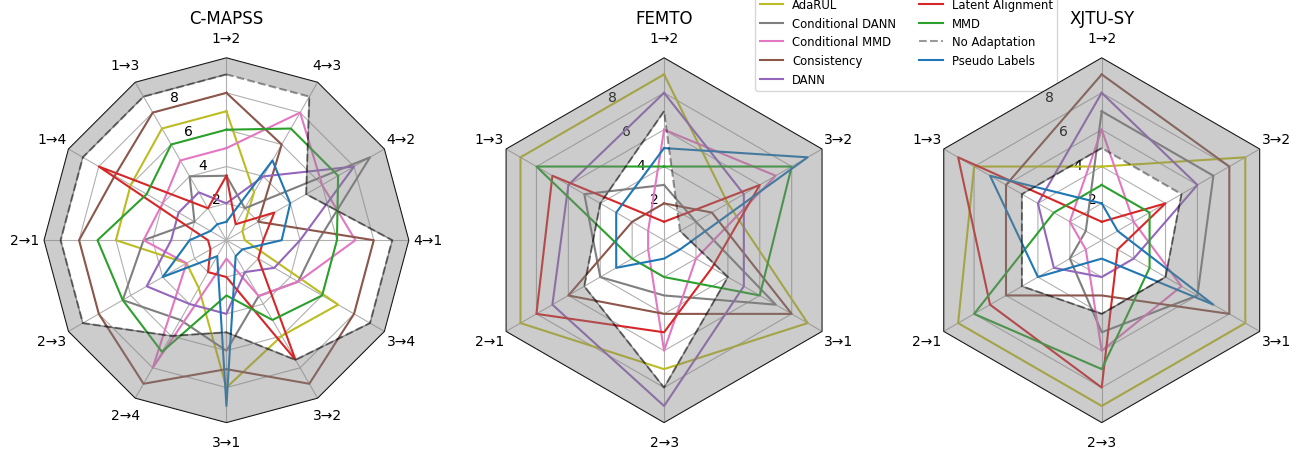

In [102]:
axes = radar(rounded.loc[("transductive", "cnn")].rank())

# Ranks Score Radar Plot

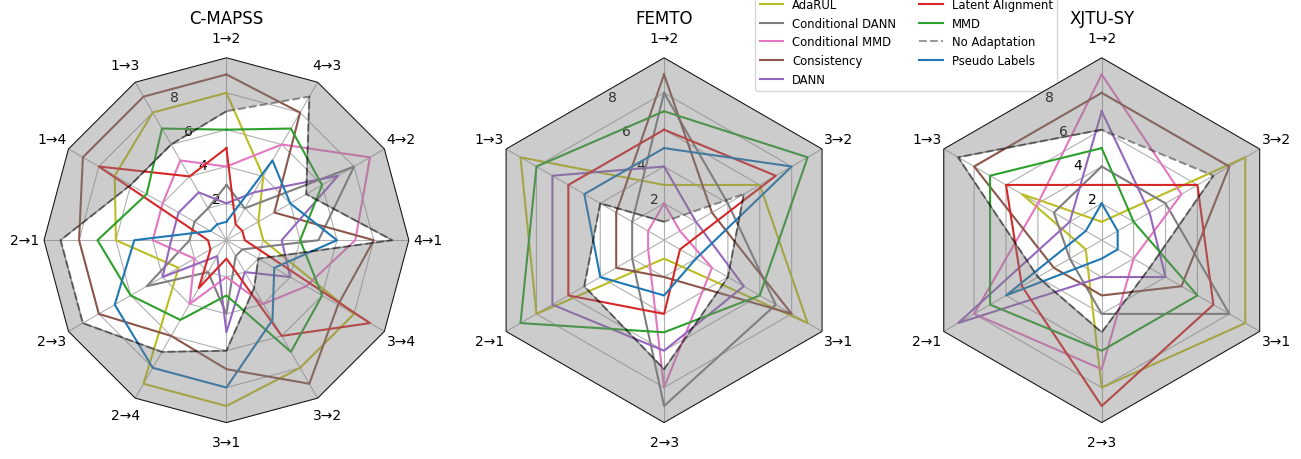

In [103]:
axes = radar(score_adjusted.loc[("transductive", "cnn")].rank())

# Average Ranks with Significance

In [104]:
def cd_plot(rmse):
    fig, axes = plt.subplots(figsize=(16, 2.5), ncols=3, nrows=1)
    for i, dataset in enumerate(["cmapss", "femto", "xjtu-sy"]):
        axis = axes[i]
        axis.set_title(dataset_names[dataset])
        plt.sca(axis)
        filtered = rmse.loc[:, (slice(None), dataset)].droplevel([0, 1], axis=1)
        filtered.columns = filtered.columns.map(lambda x: "-".join(x))
        filtered.index = filtered.index.map(approach_names.get)
        avg_ranks, significances = friedman_nemenyi(filtered)
        plot_critical_difference(
            avg_ranks, 
            significances if significances is not None else np.ones((9, 9)), 
            fig=fig,
            highlight="No Adaptation"
        )
    
    return fig

Friedman test: No significant difference between approaches.
Friedman test: No significant difference between approaches.


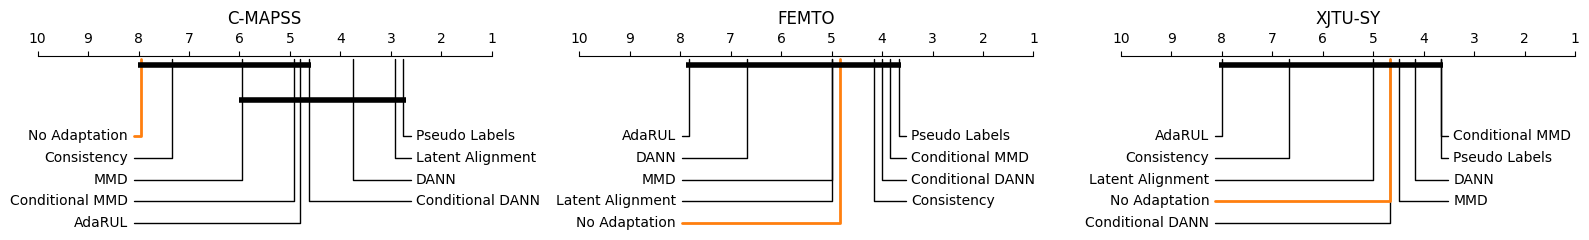

In [105]:
fig = cd_plot(rounded.loc[("transductive", "cnn")])
fig.tight_layout()
fig.savefig("plots/rmse_cd.pdf")

Friedman test: No significant difference between approaches.
Friedman test: No significant difference between approaches.


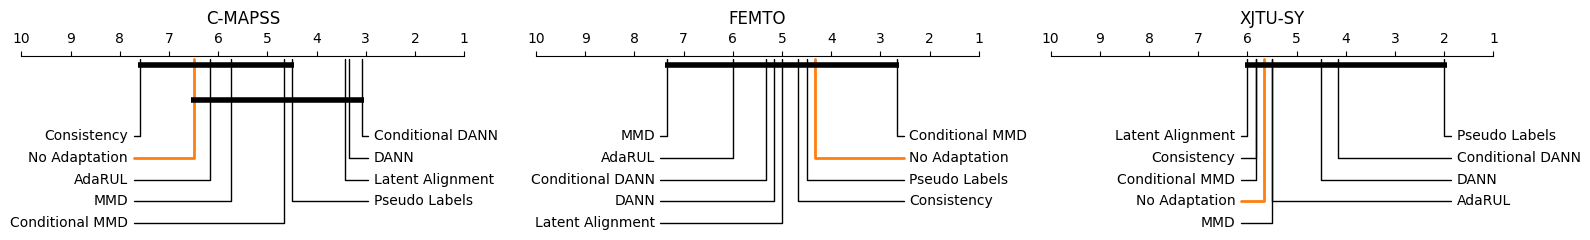

In [106]:
fig = cd_plot(score_adjusted.loc[("transductive", "cnn")])
fig.tight_layout()
fig.savefig("plots/score_cd.pdf")

# Overall Ranking
Findings:
* Pseudo Labels only approach with significant performance difference in RMSE
* No approach shows significant difference in score
* AdaRUL ranks under baseline for both
* Consistency and MMD rank above baseline for score

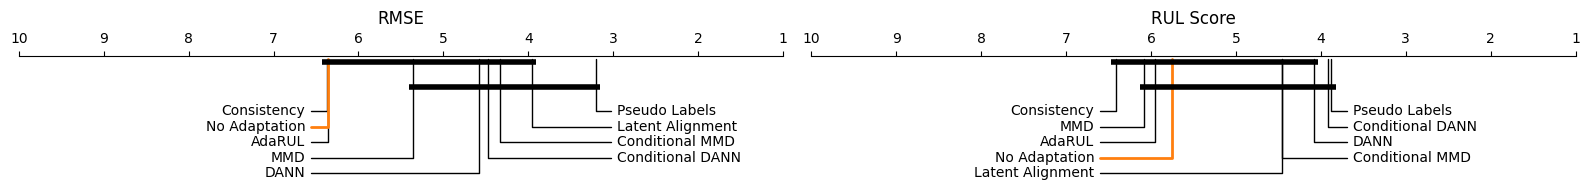

In [107]:
filtered = rounded.loc[("transductive", "cnn", slice(None))]
filtered.columns = filtered.columns.map(lambda x: "-".join(x))
filtered.index = filtered.index.map(approach_names.get)
avg_ranks, significances = friedman_nemenyi(filtered)
fig, (rmse_axis, score_axis) = plt.subplots(figsize=(16, 2), ncols=2, nrows=1)
plt.sca(rmse_axis)
_ = plot_critical_difference(
    avg_ranks, 
    significances,
    highlight="No Adaptation",
    fig=fig,
)
rmse_axis.set_title("RMSE")

filtered = score_adjusted.loc[("transductive", "cnn", slice(None))]
filtered.columns = filtered.columns.map(lambda x: "-".join(x))
filtered.index = filtered.index.map(approach_names.get)
avg_ranks, significances = friedman_nemenyi(filtered)
plt.sca(score_axis)
_ = plot_critical_difference(
    avg_ranks, 
    significances,
    highlight="No Adaptation",
    fig=fig,
)
score_axis.set_title("RUL Score")

fig.tight_layout()
fig.savefig("plots/overall_cd.pdf")

# Validation/Test Metric Correlation
Findings:
* Metrics correlate well for C-MAPSS
* Low correlation for bearing datasets
* Differences between bearing entities may be larger than domain gap

In [108]:
runs = pd.read_csv("results/runs.csv", index_col=0)

In [109]:
correlations = runs.loc[:, ("dataset", "validation", "test/target/rmse/dataloader_idx_1")].groupby("dataset").corr("spearman").loc[(slice(None), "test/target/rmse/dataloader_idx_1"), "validation"]

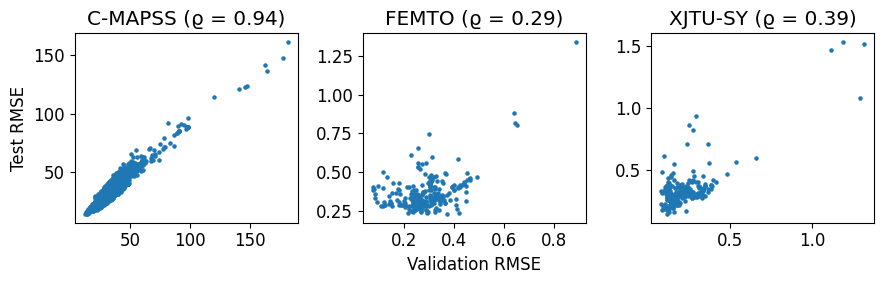

In [110]:
plt.rc('font', **{'size': 12})

fig, axes = plt.subplots(figsize=(9, 3), ncols=3)
for dataset, axis in zip(["cmapss", "femto", "xjtu-sy"], axes):
    validation = runs.loc[runs["dataset"] == dataset, "validation"]
    test = runs.loc[runs["dataset"] == dataset, "test/target/rmse/dataloader_idx_1"]
    axis.scatter(validation, test, s=5)
    axis.set_title(f"{dataset_names[dataset]} (ϱ = {correlations[dataset].item():.2f})")
    # axis.set_xticks([])
    # axis.set_yticks([])
axes[1].set_xlabel("Validation RMSE")
axes[0].set_ylabel("Test RMSE")
fig.tight_layout()
fig.savefig("plots/correlation.pdf", bbox_inches="tight")
plt.rcdefaults()